# Assignment 4 

Name: Raashna Chand

Student ID: 300607575

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
np.random.seed = 10

In [2]:
#Load dataset
df = pd.read_csv('data.csv')
df.head()

,id,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,1,132500,0.09,42.0,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,2,181115,0.92,0.0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,3,109000,0.19,133.0,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,4,155000,0.41,13.0,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,5,86060,0.11,0.0,15000,840,51,2,0,1.0,3,NaN,gas,public/commercial,No,Yes,Yes


The `id` column is irrelevant, so we will remove that.

In [3]:
del df['id']

In [4]:
#We will check if there are null or unknown values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1728 non-null   int64  
 1   lotSize          1728 non-null   float64
 2   age              1556 non-null   float64
 3   landValue        1728 non-null   int64  
 4   livingArea       1728 non-null   int64  
 5   pctCollege       1728 non-null   int64  
 6   bedrooms         1728 non-null   int64  
 7   fireplaces       1728 non-null   int64  
 8   bathrooms        1728 non-null   float64
 9   rooms            1728 non-null   int64  
 10  heating          1642 non-null   object 
 11  fuel             1728 non-null   object 
 12  sewer            1728 non-null   object 
 13  waterfront       1728 non-null   object 
 14  newConstruction  1728 non-null   object 
 15  centralAir       1728 non-null   object 
dtypes: float64(3), int64(7), object(6)
memory usage: 216.1+ KB


The columns "age" and "heating" have null values. Now we will check for unknown values that cannot be detected.

In [5]:
df['fuel'].value_counts()

fuel
gas         1197
electric     315
oil          216
Name: count, dtype: int64

In [6]:
df['sewer'].value_counts()

sewer
public/commercial    1213
septic                503
none                   12
Name: count, dtype: int64

In [7]:
df['waterfront'].value_counts()

waterfront
No     1713
Yes      15
Name: count, dtype: int64

In [8]:
df['newConstruction'].value_counts()

newConstruction
No     1647
Yes      81
Name: count, dtype: int64

In [9]:
df['centralAir'].value_counts()

centralAir
No     1093
Yes     635
Name: count, dtype: int64

There are no unknown values in the dataset, aside from in the age and heating columns.
We will now split the data into the test set and the training set (80% and 20% of the data respectively).

In [10]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)
#separate predictors and labels
X_train = train_set.drop("price", axis=1)
y_train = train_set["price"].copy()
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

We will gain some insights into the training set.

In [11]:
housing = train_set.copy()

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'lotSize'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'landValue'}>,
        <AxesSubplot:title={'center':'livingArea'}>,
        <AxesSubplot:title={'center':'pctCollege'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'fireplaces'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'rooms'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

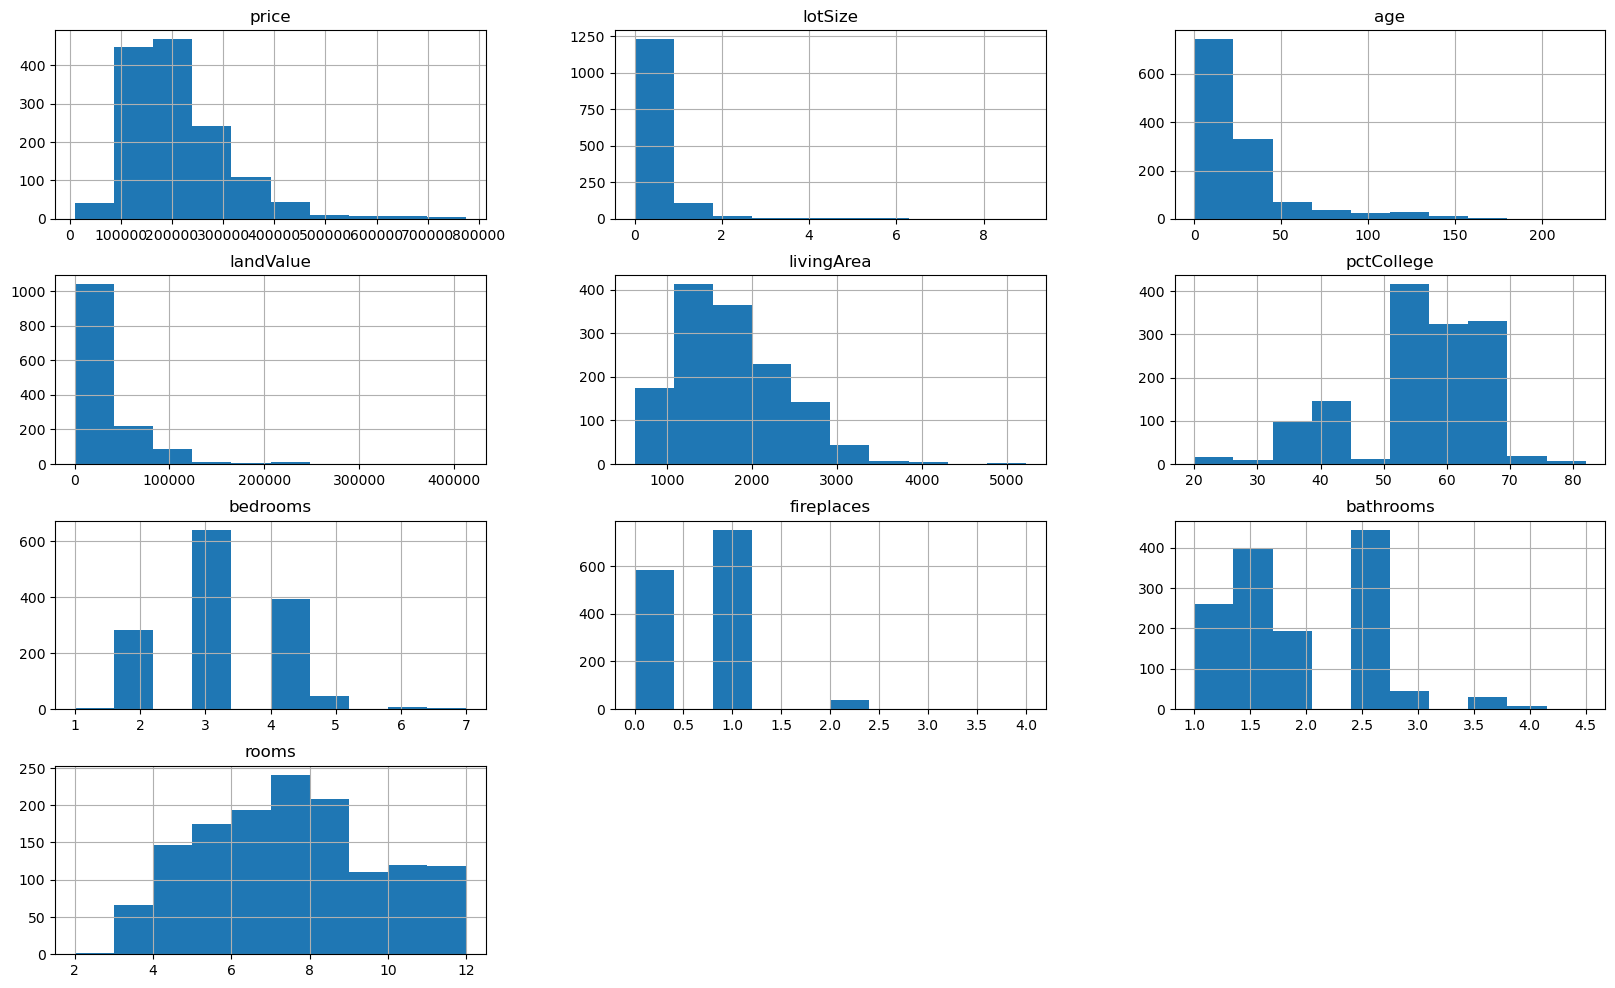

In [12]:
housing.hist(figsize=(20,12))

Most land values are less than 100,000 dollars. Most houses were built less than 50 years ago. The majority of house prices are between 100,000 dollars to 300,000 dollars.

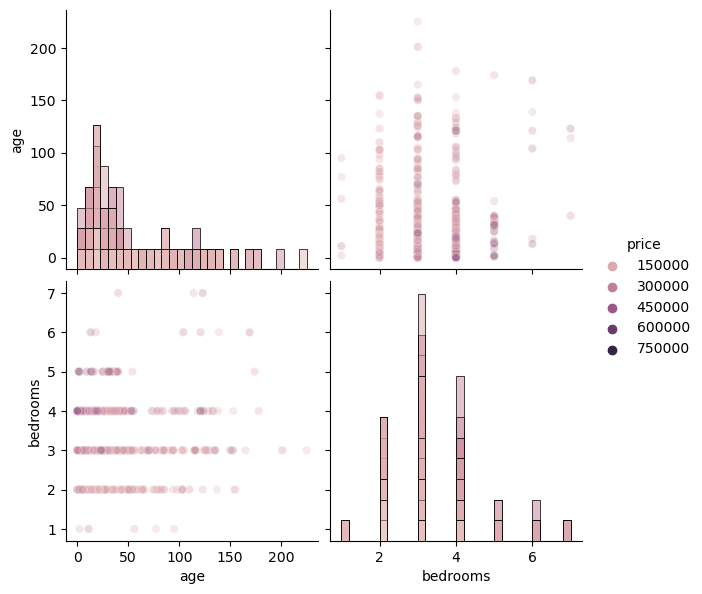

In [13]:
columns = ['age', 'bedrooms']
sns.pairplot(data=housing[:], vars=columns,
             hue="price", plot_kws={'alpha': 0.3},
             height=3, diag_kind='hist', diag_kws={'bins': 30});

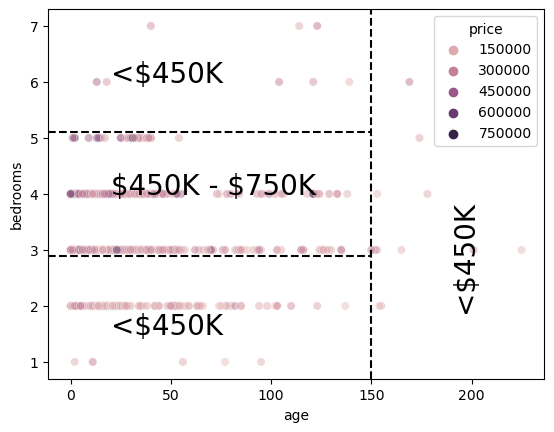

In [14]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="age", y="bedrooms", data=housing[:], hue="price", alpha=0.5)
age_limit = 150
plt.axvline(x=age_limit, ymin=0, ymax=1, color="black", linestyle="--")
bedrooms_limit_lower = 2.9
plt.axhline(y=bedrooms_limit_lower, xmin=0, xmax=0.65, color="black", linestyle="--")
bedrooms_limit_upper = 5.1
plt.axhline(y=bedrooms_limit_upper, xmin=0, xmax=0.65, color="black", linestyle="--")
plt.annotate("\$450K - \$750K", (20, 4), fontsize=20)
plt.annotate("<$450K", (20, 6), fontsize=20);
plt.annotate("<$450K", (20, 1.5), fontsize=20);
plt.annotate("<$450K", (190, 2), fontsize=20, rotation=90)
fig = plt.gcf()
#fig.savefig('age_hours_rules.pdf', bbox_inches='tight');

It appears that if you have 3-5 bedrooms and your house is less than 150 years old, you will command a higher price for your house.

Implement transformer preprocessor.

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Sort by numerical and nominal
numerical_columns = ['lotSize', 'age', 'landValue', 'livingArea', 
                     'pctCollege', 'bedrooms', 'fireplaces', 'rooms', 'bathrooms']
nominal_columns = ['heating', 'fuel', 'sewer', 'waterfront', 'newConstruction', 'centralAir']


#Define estimators, transformers, and encoders. Handle unknowns by ignoring them
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                               ('scaler', StandardScaler())])
nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Apply these transformers to the columns
preprocessor = ColumnTransformer([('numerical_transformer', numerical_pipeline, numerical_columns),
                                  ('nominal_transformer', nominal_pipeline, nominal_columns)])

Evaluate models. Choosing linear regression first.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

lr_model = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])

lr_model.fit(X_train, y_train);

y_train_predicted = lr_model.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))

cv_results = cross_validate(lr_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

RMSE on the training set: 57971.2765
The mean cross-validation RMSE is:  59010.6735 +/- 5697.4381


Now doing SVR.

In [17]:
from sklearn.svm import SVR

svm_model = Pipeline([('preprocessor', preprocessor), ('regressor', SVR())])

svm_model.fit(X_train, y_train);

y_train_predicted = svm_model.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))

cv_results = cross_validate(svm_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

RMSE on the training set: 102141.0319
The mean cross-validation RMSE is:  101823.0452 +/- 9748.4073


Using `GridSearchCV` to tune hyperparameters `gamma` and `c`.

In [18]:
param_grid = [{'regressor__C': [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
               'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 'scale', 'auto']},
             ]

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train);

print('Best hyperparameters:', grid_search.best_params_)
print('Best RMSE from GridSearchSV:', np.sqrt(-grid_search.best_score_))

Best hyperparameters: {'regressor__C': 1000000, 'regressor__gamma': 0.01}
Best RMSE from GridSearchSV: 59102.392126292325


In [19]:
y_train_predicted = grid_search.best_estimator_.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))

cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

RMSE on the training set: 54026.6769
The mean cross-validation RMSE is:  58789.2389 +/- 6076.0305


The SVR model with adjusted hyperparameters has the lowest RMSE on the training set, therefore this model fits best.

Now we compute the RMSE of the test set using the optimised SVR model.

In [20]:
y_test_predicted = grid_search.best_estimator_.predict(X_test)
print("RMSE of the optimized SVR model on the test set: %.4f" % np.sqrt(mean_squared_error(y_test,y_test_predicted)))

RMSE of the optimized SVR model on the test set: 60315.3168


We will compare this with the RMSE of the linear regression model and the SVR model.

We will also report on the Mean Absolute Percentage Error and the R^2 score.

In [21]:
from sklearn.metrics import mean_absolute_percentage_error
print(f"Mean absolute percentage error: "
f"{mean_absolute_percentage_error(y_test, y_test_predicted) * 100:.4f} %")

Mean absolute percentage error: 32.5379 %


In [22]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_predicted)
print(f'R-squared score: {r2}')

R-squared score: 0.5850823192356978


These values suggest the model is not a good fit for the housing data. While the RMSE for the adjusted SVR model was the lowest from all models done, the value is still relatively high, meaning that the predictions of the house prices are significantly off from the actual prices. This is also indciated by the high mean absolute percentage error. The R-squared score is negative, which means that the model does not explain any variance that exists in the data. Other models could have been explored on the training data beforehand, and perhaps more parameters should have been adjusted. More data could have possibly resulted in a better trained model. In the future, I would like to know more models that we can use to fit data and ways to tweak parameters and estimators.